<a href="https://colab.research.google.com/github/Chdunham/SUREResearch2021/blob/main/SURE_Pt8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
# Get Adult data from UCI repository: https://archive.ics.uci.edu/ml/datasets/adult
# >50K, <=50K.
# age: continuous.
#workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
# relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
# race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.


import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
tf.__version__

# Source: https://fairmlbook.org/code/adult.html

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)
original_test

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [136]:
Variable_scale = 1000
original = pd.concat([original_test, original_train])
original = original.dropna()

Mask = (original['Sex'] == 'Male') & ((original['Target'] == '<=50K') | (original['Target'] == '<=50K.'))
LessMale = original[Mask]

Mask = (original['Sex'] == 'Male') & ((original['Target'] == '>50K') | (original['Target'] == '>50K.'))
MoreMale = original[Mask]

Mask = (original['Sex'] == 'Female') & ((original['Target'] == '<=50K') | (original['Target'] == '<=50K.'))
LessFemale = original[Mask]

Mask = (original['Sex'] == 'Female') & ((original['Target'] == '>50K') | (original['Target'] == '>50K.'))
MoreFemale = original[Mask]

original = pd.concat([LessMale[:Variable_scale],\
                      MoreMale[:Variable_scale], \
                      LessFemale[:Variable_scale], MoreFemale[:Variable_scale]])
original = original.sample(frac=1)
original

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
1564,24,Private,206891,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K.
290,42,Private,171615,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,>50K.
3449,21,Private,376393,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Female,0,0,25,United-States,<=50K.
519,64,State-gov,107732,1st-4th,2,Married-civ-spouse,Farming-fishing,Husband,Other,Male,0,0,45,Columbia,<=50K.
2351,31,Private,220066,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,14344,0,50,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10790,40,Private,226585,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,35,United-States,>50K
1010,58,Local-gov,218724,HS-grad,9,Widowed,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K.
3364,41,Self-emp-inc,130126,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States,>50K.
596,38,Private,93140,HS-grad,9,Separated,Machine-op-inspct,Unmarried,Black,Female,0,0,28,United-States,<=50K.


In [137]:
num_train = len(original)
roc_original = original
labels = original['Target']
print(labels.head)
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
labels.head()

<bound method NDFrame.head of 1564     <=50K.
290       >50K.
3449     <=50K.
519      <=50K.
2351       >50K
          ...  
10790      >50K
1010     <=50K.
3364      >50K.
596      <=50K.
261      <=50K.
Name: Target, Length: 4000, dtype: object>


1564    0
290     1
3449    0
519     0
2351    1
Name: Target, dtype: int64

In [138]:

# Drop rows with missing values.
labels = original['Target']

labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
# Make categorical columns numeric (one-hot encoding).
# Normalize.
X = pd.get_dummies(original.drop(['fnlwgt', 'Target'], axis = 1))
y = labels
y

1564     0
290      1
3449     0
519      0
2351     1
        ..
10790    1
1010     0
3364     1
596      0
261      0
Name: Target, Length: 4000, dtype: int64

In [139]:
# Get separate training and test sets.
import numpy as np
from sklearn.model_selection import train_test_split

# get train and test data from our set and outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# Normalize data to read easier for ML
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [142]:
from tensorflow import keras
# Look @ overfitting
# How do we run machine learning experiments? What are best practices, loss curves
# train/test sets, validation sets
# Look at in graphs
model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(75, activation='relu'))

#model.add(Dense(50, activation='relu'))

#model.add(Dense(25, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

epoch = 10

batch = 265

# Learning rate in model.compile? 1e - 2, 1.5e - 3
tf.keras.optimizers.Adam(
    learning_rate=0.01, epsilon=1e-07, amsgrad=False,
    name='adam'
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.1)

model.test_on_batch(X_test, y_test)
model.metrics_names


Epoch 1/10
10/10 [==============================] - 1s 32ms/step - loss: 0.6804 - accuracy: 0.5961 - val_loss: 0.5561 - val_accuracy: 0.7571
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.5142 - accuracy: 0.7910 - val_loss: 0.4867 - val_accuracy: 0.7714
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.4446 - accuracy: 0.8115 - val_loss: 0.4624 - val_accuracy: 0.7964
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.4071 - accuracy: 0.8247 - val_loss: 0.4538 - val_accuracy: 0.8071
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.3913 - accuracy: 0.8208 - val_loss: 0.4455 - val_accuracy: 0.8179
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.3589 - accuracy: 0.8354 - val_loss: 0.4401 - val_accuracy: 0.8143
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.3632 - accuracy: 0.8278 - val_loss: 0.4369 - val_accuracy: 0.8107
Epoch 8/10
10/10 [=

['loss', 'accuracy']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


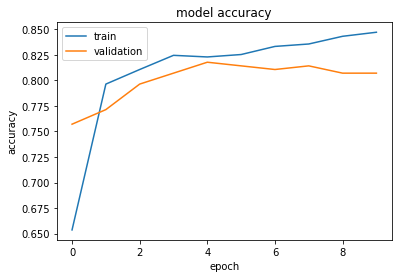

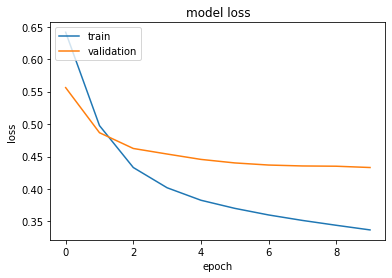

In [143]:
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()